In [ ]:
import pandas as pd

df = pd.read_csv('Stress.csv')

In [ ]:
df

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df).train_test_split(test_size=0.1, seed=44)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['subreddit', 'post_id', 'sentence_range', 'text', 'label', 'confidence', 'social_timestamp'],
        num_rows: 2554
    })
    test: Dataset({
        features: ['subreddit', 'post_id', 'sentence_range', 'text', 'label', 'confidence', 'social_timestamp'],
        num_rows: 284
    })
})

In [ ]:
example = dataset['train'][0]
example

{'subreddit': 'relationships',
 'post_id': '7r7f7b',
 'sentence_range': '[10, 15]',
 'text': 'Therefore, it should probably come as no surprise that I sprung the question of "What exactly are we doing here?". Well, that backfired, as he alluded to the fact he was too freshly out of a long term relationship and didn\'t want to commit yet (Jason had been single for more than a year and it was a 3 year relationship). I bit my tongue until it bled and told him that was okay because we had more friends in common by that point, despite saying I needed some direct space for a few weeks or more. Unfortunately, what followed could have not been more violent. Not the type of physical violence, but emotional tension and turmoil fueled by running into each other at social settings and by alcohol.',
 'label': 1,
 'confidence': 1.0,
 'social_timestamp': 1516252178}

In [ ]:
labels = ['label']
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}
labels

['label']

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def preprocess_data(examples):
    text = examples["text"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)

    encoding["labels"] = [
        [float(1 - examples['confidence'][index]), float(examples['confidence'][index])] if el == 1 else
        [float(examples['confidence'][index]), float(1 - examples['confidence'][index])]
        for index, el in enumerate(examples['label'])]

    encoding["labels"] = [[float(el)] for index, el in enumerate(examples['label'])]

    return encoding

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/2554 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

In [ ]:
example = encoded_dataset['train'][15]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

"[CLS] hey everyone, throwaway for personal reasons. tonight my girlfriend met her lady friend she didn't see for a year. i bought them wine, paid for dinner and was happy to give them the entire night if they wanted to so they could spend time together. later on in the night i received a call at 1am requesting me to take her home. i get there and there's a person i've literally never seen before, a guy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
example['labels']

[0.0]

In [ ]:
encoded_dataset.set_format("torch")

In [ ]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-stress-classifier",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=1e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    # load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch


def multi_label_metrics(predictions, labels, threshold=0.5):
    #  sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    #  threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_dataset['train'][0]['input_ids'].unsqueeze(0)

tensor([[  101,  3568,  1010,  2009,  2323,  2763,  2272,  2004,  2053,  4474,
          2008,  1045, 22057,  1996,  3160,  1997,  1000,  2054,  3599,  2024,
          2057,  2725,  2182,  1029,  1000,  1012,  2092,  1010,  2008,  2067,
         10273,  2094,  1010,  2004,  2002,  2035, 13936,  2000,  1996,  2755,
          2002,  2001,  2205, 20229,  2041,  1997,  1037,  2146,  2744,  3276,
          1998,  2134,  1005,  1056,  2215,  2000, 10797,  2664,  1006,  4463,
          2018,  2042,  2309,  2005,  2062,  2084,  1037,  2095,  1998,  2009,
          2001,  1037,  1017,  2095,  3276,  1007,  1012,  1045,  2978,  2026,
          4416,  2127,  2009, 23919,  1998,  2409,  2032,  2008,  2001,  3100,
          2138,  2057,  2018,  2062,  2814,  1999,  2691,  2011,  2008,  2391,
          1010,  2750,  3038,  1045,  2734,  2070,  3622,  2686,  2005,  1037,
          2261,  3134,  2030,  2062,  1012,  6854,  1010,  2054,  2628,  2071,
          2031,  2025,  2042,  2062,  6355,  1012,  

In [ ]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  3568,  1010,  2009,  2323,  2763,  2272,  2004,  2053,  4474,
         2008,  1045, 22057,  1996,  3160,  1997,  1000,  2054,  3599,  2024,
         2057,  2725,  2182,  1029,  1000,  1012,  2092,  1010,  2008,  2067,
        10273,  2094,  1010,  2004,  2002,  2035, 13936,  2000,  1996,  2755,
         2002,  2001,  2205, 20229,  2041,  1997,  1037,  2146,  2744,  3276,
         1998,  2134,  1005,  1056,  2215,  2000, 10797,  2664,  1006,  4463,
         2018,  2042,  2309,  2005,  2062,  2084,  1037,  2095,  1998,  2009,
         2001,  1037,  1017,  2095,  3276,  1007,  1012,  1045,  2978,  2026,
         4416,  2127,  2009, 23919,  1998,  2409,  2032,  2008,  2001,  3100,
         2138,  2057,  2018,  2062,  2814,  1999,  2691,  2011,  2008,  2391,
         1010,  2750,  3038,  1045,  2734,  2070,  3622,  2686,  2005,  1037,
         2261,  3134,  2030,  2062,  1012,  6854,  1010,  2054,  2628,  2071,
         2031,  2025,  2042,  2062,  6355,  1012,  2025,   102])

In [ ]:
outputs = model(input_ids=encoded_dataset['train'][0]['input_ids'].unsqueeze(0),
                labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6287, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[0.1334]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Let's start training!

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [1]:
history = trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.659167,0.602113,0.585124,0.602113
2,No log,0.587425,0.728873,0.723433,0.728873
3,No log,0.537423,0.764085,0.760348,0.764085
4,0.620700,0.503808,0.781690,0.778209,0.781690
5,0.620700,0.482731,0.778169,0.773682,0.778169
6,0.620700,0.454386,0.813380,0.813781,0.813380
7,0.485500,0.446598,0.806338,0.803930,0.806338
8,0.485500,0.429061,0.820423,0.820846,0.820423
9,0.485500,0.423258,0.830986,0.830448,0.830986
10,0.419200,0.416423,0.830986,0.830050,0.830986


In [ ]:
trainer.save_model(f'best_model')

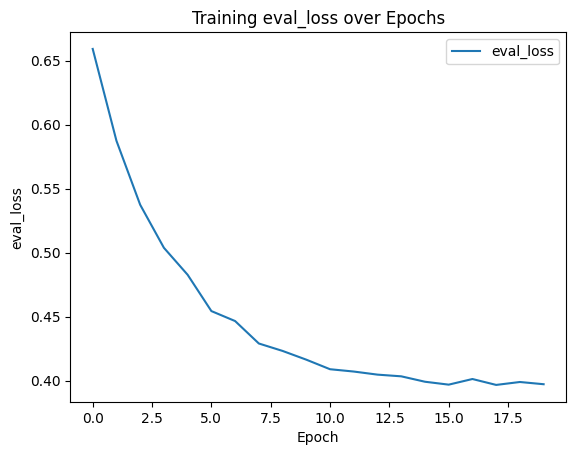

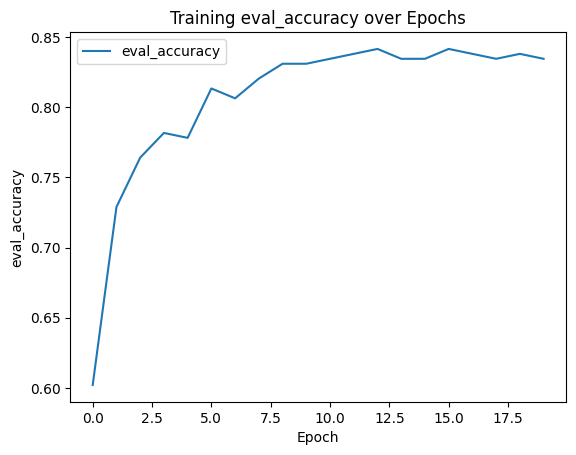

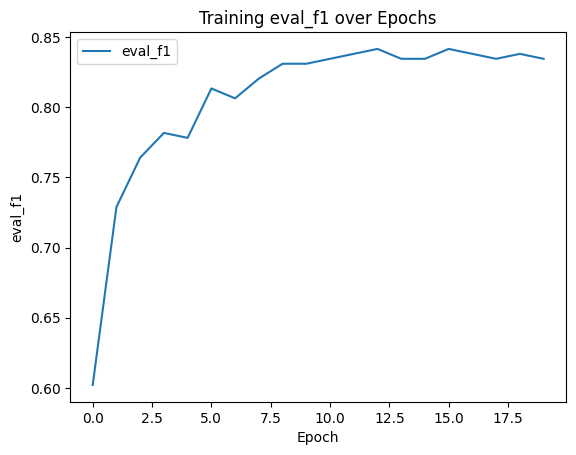

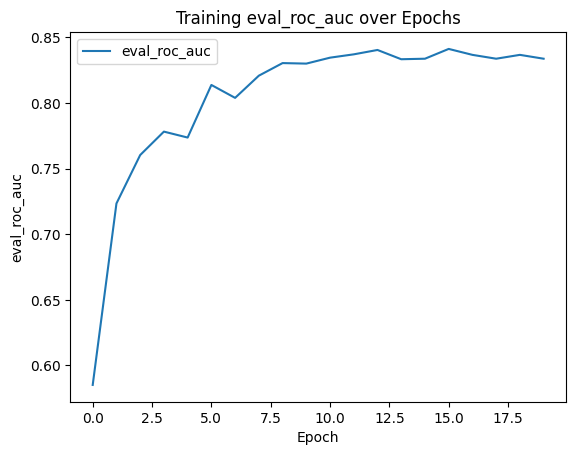

In [ ]:
import matplotlib.pyplot as plt


def plot_metric(trainer_history, metric_name):
    data = list(filter(lambda x: metric_name in x, trainer_history))
    data = list(map(lambda x: x[metric_name], data))
    plt.plot(data, label=metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Training {metric_name} over Epochs')
    plt.legend()
    plt.show()


plot_metric(trainer.state.log_history[:-1], 'eval_loss')
plot_metric(trainer.state.log_history[:-1], 'eval_accuracy')
plot_metric(trainer.state.log_history[:-1], 'eval_f1')
plot_metric(trainer.state.log_history[:-1], 'eval_roc_auc')



In [4]:
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 886
  Batch size = 16


{'epoch': 20.0,
 'eval_accuracy': 09379909706546275,
 'eval_f1': 0.8596149188665537,
 'eval_loss': 0.31915703415870667,
 'eval_roc_auc': 0.845805895058838,
 'eval_runtime': 4.7187,
 'eval_samples_per_second': 187.766,
 'eval_steps_per_second': 23.524}



In [ ]:
text = "I'm happy I can finally train a model for multi-label classification and finish it"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 11])